# Calculating the absorption and scattering cross section using a probability distribution

In [1]:
import time
# AA = time.time()
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spit
import os
print('hello world')


hello world


### This defines the probability distribution

In [2]:
def probability(dis_name, l1, l2, lmin=0.05, m1=0, m2=0, d=0):
    '''
    This is the probability distribution as a function of L1 and L2, the 
    geometric parameters. This parameter gets inserted into the integral that 
    calculates the average polarizability per unit volume

    Parameters
    ----------
    dis_name : String
        This specifies the distribution we will be using. 
        'CDE' = Continuous Distribution of Ellipsoids
        'ERCDE' = Externally Restricted CDE, returns CDE if lmin=0
        'tCDE' = truncated CDE, REQUIRES MORE WORK
    l1 : Float
        Largest Geometric Constant, lmin<l1<1.0
    l2 : Float
        Second Largest Geometric Constant, lmin<l2<=l1
    lmin : Float, optional
        Minimum allowed geometric constant.  The default is 0.

    Returns
    -------
    Float
        Function dependent on l1 and l2

    '''
    l3 = 1 - l1 - l2
    if dis_name == 'CDE':
        return 2
    elif dis_name == 'CDE2':
        return 120 * l1 * l2 * l3
    elif dis_name == 'ERCDE':
        return 2/((1 - (3*lmin))**2)
    elif dis_name == 'tCDE':
        return 1/((1-d-m2)*(1-m1-m2-d) - 0.5*((1-d-m2)**2) - m1**2)
    else:
        return True
        
    
print('hello world')

hello world


### I think it would be easier to make the tCDE its own function

In [ ]:
def prob_tCDE(m1,m2,d):
    return 1/((1-d-m2)*(1-m1-m2-d) - 0.5*((1-d-m2)**2) - m1**2)

### Now we define our volume function. v_avg is used to calculate sigma below

In [3]:
def volume_integrand_mrn(r, q):
    v = r**(-q)
    return v

# UNITS ARE IN MICRONS
rmin = 0.005
rmax = 0.25
q = 3.5

r_integral = spit.quad(volume_integrand_mrn, rmin, rmax, args=q)
r_average = ((1/(rmax - rmin)) * r_integral[0])**(1/-q)
v_avg = (4./3.) * np.pi * r_average**3



### creates function that calculates Sigma, defined in eq 13 in Min et al 2003

In [4]:
def sigma(m, lamda, v):
    sig = []
    for i in range(len(lamda)):
        k = (2.0 * np.pi)/lamda[i]
        term1 = (6.0*np.pi) / (v * (k**3))
        term2 = np.imag((m[i]**2))
        term3 = 1.0 / abs(m[i]**2 - 1)**2
        sig.append(term1 * term2 * term3)
    return sig
print('hello world')

hello world


### creates our bounds for our geometric factors. The bounds are the sides of a triangle in (l1, l2) space

In [5]:
def bounds_l1():
    return [0,1]

def bounds_l2(l1):
    return [0,1-l1]
print('hello world')


hello world


### This is where we calculate the absorption cross-section (Cabs). It creates an empty list, then calculates Cabs for a given distribution at each wavelength as described in Min 03, eqn 15. It then uses this to find the shape averaged mass absorption coefficient for particles of a given volume, as described in Min 03, eqn 39

In [6]:
def cabs(m, dis_name, bounds_l2, bounds_l1):
    cabs = []
    if dis_name=='spheres':
        for j in range(len(m)):
            cabs.append(np.imag(3*(m[j]**2 - 1)/(m[j]**2 + 2)))
    else:
        for j in range(len(m)):
            def f(l1, l2, n=m[j], dis_name='CDE'):
                b = 1/(n**2 - 1)
                term1 = 1/3 * 1/(b + l1)
                term2 = 1/3 * 1/(b + l2)
                term3 = 1/3 * 1/(b + 1 - l1 - l2)
            # r = np.real((term1 + term2 + term3)*probability(dis_name, l1, l2))
                j = np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
                return j
            # return np.real((term1 + term2 + term3)*probability(dis_name, l1, l2)) + np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
            cabs.append(spit.nquad(f, [bounds_l2, bounds_l1])[0])
    return cabs

# j = cabs(m, 'spheres', bounds_l2, bounds_l1)
# # dust = 'grph1-dl.nk'                  #DUST NAME HERE #grf
# # rho = 3.33 #grams cm**-3            #density
# # pathy = os.path.join(nk_path, dust) #pipeline is open
# # wavelen, n_dust, k_dust = np.loadtxt(pathy, skiprows=7, unpack=True)
# #                                     #lamda, n, and k values are extracted
# # m = np.array([complex(n_dust[i], k_dust[i]) for i in range(len(wavelen))])
# k = cabs(m, 'CDE', bounds_l2, bounds_l1)

# print(j)
# # print('')
# print(k)







# Specify which dust we are using

In [7]:
dustlist = [('grph1-dl.nk', 'spheres'), ('sil-dlee.nk', 'spheres'), ('grph2-dl.nk', 'spheres')]
namelist = [dustlist[j][0][:-3]+dustlist[j][1]+'.dat' for j in range(len(dustlist))]
weightlist = [15.6, 53, 31.3]

dust_dir = ['/home/physics/Research/DUSTY/DUSTY/Lib_nk/', 
            "C:/UTSA/Research/DUSTY/DUSTY/Lib_nk/"]
# this is the possible locations of where dust can be


nk_path = dust_dir[1]               #where the dust is 

# lam_max, cabs_max, csca_max = np.loadtxt(max(namelist, key=os.path.getsize), unpack=True)

# output = np.zeros((len(dustlist), len(lam_max), 3))


for j in range(len(dustlist)):
    pathy = os.path.join(nk_path, dustlist[j][0]) #pipeline is open
    wavelen, n_dust, k_dust = np.loadtxt(pathy, skiprows=7, unpack=True)
    m = np.array([complex(n_dust[i], k_dust[i]) for i in range(len(wavelen))])
    cab = cabs(m, dustlist[j][1], bounds_l2, bounds_l1)
    Cabs_array = np.array((cab))
    Cabs_array *= (2 * np.pi / (wavelen)) * v_avg
    sig = np.array((sigma(m, wavelen, v_avg)))
    Csca_array = Cabs_array/sig
    output = np.transpose((wavelen, Cabs_array, Csca_array))
    f = open(dustlist[j][0][:-3]+dustlist[j][1]+'.dat', 'w')
    for i in range(len(output)):
        f.write(f"{output[i,0]} \t {output[i,1]} \t {output[i,2]}\n")
    f.close()

    
    


lam_final = np.geomspace(0.2, 500, num=500)
total_array = np.ndarray((3,len(lam_final),len(dustlist)))
total_array[:,:,0] = lam_final

for k in range(len(namelist)):
    lam, cabs_tot, csca_tot = np.loadtxt(namelist[k], unpack=True)
    total_array[k,:,1] = np.interp(lam_final, lam, cabs_tot)
    total_array[k,:,2] = np.interp(lam_final, lam, csca_tot)


    
avg_array = np.ndarray((len(lam_final),3))
avg_array[:,0] = lam_final
for j in range(len(lam_final)):
    avg_array[j,1] = np.average(total_array[:,j,1], weights=weightlist)
    avg_array[j,2] = np.average(total_array[:,j,2], weights=weightlist)

    
    
titlestring=''
for g in range(len(namelist)):
    titlestring += namelist[g][:3] + str(weightlist[g]).replace('.','')
    
f = open(titlestring+'.dat','w')
for i in range(len(lam_final)):
    f.write(f"{avg_array[i,0]} \t {avg_array[i,1]} \t {avg_array[i,2]}\n")
f.close() 
    
    
    
    
    
    
print('hello world')


hello world


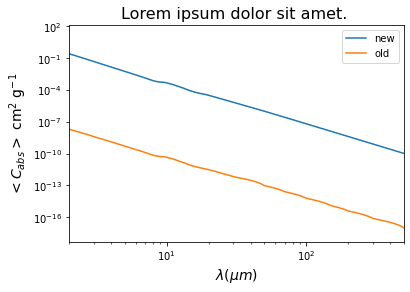

In [23]:
lam_new, cab_new, csa_new = np.loadtxt('ism.dat', unpack=True, skiprows=3)
lam_old, cab_old, csa_old = np.loadtxt('grp156sil53grp313.dat', unpack=True)


fig, ax = plt.subplots()
title = 'Lorem ipsum dolor sit amet. '
ax.set(xscale='log', yscale='log', xlim=(2,500))
ax.set_title(title, fontsize=16)
ax.set_xlabel(r'$\lambda (\mu m)$', fontsize=14)
ax.set_ylabel(r'$<C_{abs}>$ cm$^{2}$ g$^{-1}$', fontsize=14)
ax.plot(lam_new, csa_new, label='new')
ax.plot(lam_old, csa_old, label='old')
# ax.plot(wavelen, np.array((cabs_ercde)), label='ERCDE')
ax.legend()

In [19]:
plt.close('all')